# COVID-19 日本における感染者数の推移予測
日本以外の新規感染者数及び累計については[WHO発表](https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports)による。
日本の新規感染者数及び累計については[NHKまとめ](https://www3.nhk.or.jp/news/special/coronavirus/data-widget/)による。
日本の新規感染者数の予測に用いている都道府県ごとの感染者数については[厚労省発表](https://covid19.mhlw.go.jp/)による。
いずれにおいても、元データからのグラフや予測の作成は筆者。

## 必要なライブラリの読み込み
使用するライブラリは
- pandas : 表データの扱い
- numpy : 数値計算
- matplotlib : グラフを描く
- scipy : 近似用

_import_ で読み込み。_as_ を付けることで、後のコード中でその名前でライブラリに含まれる関数を使うことができる。

_from ライブラリ名 import 関数名_ 句を使うと、巨大なライブラリから特定の関数だけ抜き出して使うことができる。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

WHOの最新のDataTableをダウンロードする。

In [2]:
url = "https://covid19.who.int/WHO-COVID-19-global-data.csv"
df_raw = pd.read_csv(url)

列名を加工。興味のある国を抽出。

In [3]:
df = df_raw.rename(columns={" Country":"Country", " New_cases":"New_cases", " Cumulative_cases":"Cumulative_cases", " New_deaths":"New_deaths", " Cumulative_deaths":"Cumulative_deaths"})
df = df[["Country", "Date_reported", "New_cases", "Cumulative_cases", "New_deaths", "Cumulative_deaths"]]
df["Date_reported"] = pd.to_datetime(df["Date_reported"])
df = df.set_index(["Country", "Date_reported"])
df = df.rename(index={"Republic of Korea":"Korea", "United States of America":"USA"})
#Countries = ["Japan", "China", "Korea", "Singapore", "Germany", "France", "Italy", "USA"]
Countries = ["China", "Korea", "Singapore", "Germany", "France", "Italy", "USA"]
Ccolor = ["red", "orange", "blue", "cyan", "yellow", "magenta", "green", "black"]
df = df.loc[(Countries, slice(None)), :]
df.head()

New_cases  Cumulative_cases  New_deaths  \
Country Date_reported                                            
China   2020-01-03             0                 0           0   
        2020-01-04             1                 1           0   
        2020-01-05             0                 1           0   
        2020-01-06             3                 4           0   
        2020-01-07             0                 4           0   

                       Cumulative_deaths  
Country Date_reported                     
China   2020-01-03                     0  
        2020-01-04                     0  
        2020-01-05                     0  
        2020-01-06                     0  
        2020-01-07                     0

日本の感染者数データについては、NHKのデータをダウンロードする。

In [4]:
import requests
import io

In [5]:
url_nhk = "https://www3.nhk.or.jp/n-data/opendata/coronavirus/nhk_news_covid19_domestic_daily_data.csv"
session = requests.session()
r = session.get(url_nhk)
if r.status_code == requests.codes.ok:
  df_nhk = pd.read_csv(io.StringIO(r.text))
df_nhk = df_nhk.rename(columns={"日付":"Date_reported", "国内の感染者数_1日ごとの発表数":"New_cases", "国内の感染者数_累計":"Cumulative_cases", "国内の死者数_1日ごとの発表数":"New_deaths", "国内の死者数_累計":"Cumulative_deaths"})
df_nhk["Date_reported"] = pd.to_datetime(df_nhk["Date_reported"])
df_nhk = df_nhk.set_index("Date_reported")
df_nhk.head()

,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
Date_reported,,,,
2020-01-16,1,1,0,0
2020-01-17,0,1,0,0
2020-01-18,0,1,0,0
2020-01-19,0,1,0,0
2020-01-20,0,1,0,0


グラフを描画

In [6]:
df_date = pd.DataFrame(pd.date_range(start="2020-01-04", end=pd.Timestamp.today(), freq="D"), columns=["date"])
d = dict()
d["Japan"] = pd.merge(df_date, df_nhk, left_on="date", right_on="Date_reported", how="left")
d["Japan"] = d["Japan"].set_index("date")
#d["Japan"] = d["Japan"].fillna(0)
for c in Countries:
    d[c] = pd.merge(df_date, df.loc[c], left_on="date", right_on="Date_reported", how="left")
    d[c] = d[c].set_index("date")
df_pick = pd.concat(d, axis=1)
df_pick["day_index"] = df_pick.index.dayofweek
xticks = df_pick.index.strftime("%Y/%m/%d")
#xticks = df_pick["date"].dt.strftime("%Y/%m/%d")
x_latent = np.arange(len(df_pick))
Countries = ["Japan", "China", "Korea", "Singapore", "Germany", "France", "Italy", "USA"]


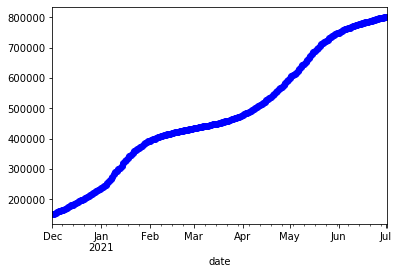

In [7]:
df_pick["Japan", "Cumulative_cases"]["2020-12":].plot(style="bo")

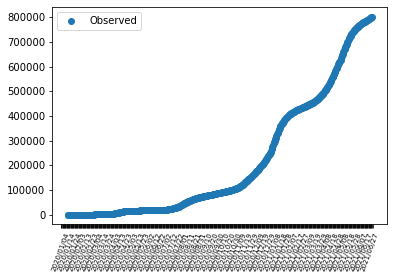

In [8]:
plt.scatter(x_latent, df_pick["Japan", "Cumulative_cases"], label="Observed")
plt.xticks(x_latent, [e if i%10==0 else "" for i,e in enumerate(xticks)], fontsize=7, rotation=70);
plt.legend();

渡された次数に応じて数式の文字列を作る関数を作成。

In [9]:
def gen_eq_str(coefficients:list, x:str="x", y:str="y"):
    s = ""
    if len(coefficients) == 0:
        s += " 0"
    else:
        for i, coef in enumerate(coefficients):
            if i == len(coefficients) - 1:
                s += " {} {:.2f}".format("+" if coef>0 else "-", np.abs(coef))
            elif i == len(coefficients) - 2:
                s += " {} {:.2f} {}".format("+" if coef>0 else "-", np.abs(coef), x)
            else:
                s += " {} {:.2f} {}^{}".format("+" if coef>0 else "-", np.abs(coef), x, len(coefficients)-i-1)
    if s[1] == "+":
        s = s[2:]
    return "{} ={}".format(y, s)

print(gen_eq_str([-2]))
print(gen_eq_str([1, -2], y="z"))
print(gen_eq_str([5, -6, -7], x="t"))

y = - 2.00
z = 1.00 x - 2.00
y = 5.00 t^2 - 6.00 t - 7.00


渡されたデータ列に対して、指定された範囲で近似曲線を描画する関数を作成。

In [10]:
def draw_approx_curve(x_data:np.ndarray, y_data:np.ndarray, r:range, 
    deg:int, forecast:int=14, color:str="green", info:str=""):
    x = [x_data[i] for i in r] - x_data[r.start]
    y = [y_data[i] for i in r] - y_data[r.start]
    coef = np.polyfit(x, y, deg)
    coef[deg] += y_data[r.start]
    x_f = [x_data[i] for i in range(r.start, r.stop + r.step * forecast, r.step)]
    curve = np.poly1d(coef)(x_f - x_data[r.start])
    label = gen_eq_str(coef, x="t")
    label = label[:label.rfind("t")+1]  # omit intercept
    plt.plot(x_f, curve, c=color, label="{} {}".format(label, info))

指数関数用の近似曲線を描画する関数

In [11]:
def draw_approx_exp_curve(x_data:np.ndarray, y_data:np.ndarray, r:range, 
    forecast:int=14, color:str="green", info:str=""):
    x = [x_data[i] for i in r] - x_data[r.start]
    y = [y_data[i] for i in r] - y_data[r.start]

    # detect convex with Jensen`s low
    slope = (y[-1] - y[0])/(x[-1] - x[0])
    intercept = y[0] - slope * x[0]
    sum_slope = sum(slope * x + intercept)
    sum_obs = sum(y)

    def func(x, a, b, c):
        if slope >= 0:
            if sum_obs < sum_slope: # Convex function
                return a*np.exp(x/b) + c
            else: # Downward-convex function
                return c - a*np.exp(-x/b)
        else:
            if sum_obs < sum_slope: # Convex function
                return a*np.exp(-x/b) + c
            else: # Downward-convex function
                return c - a*np.exp(x/b)
    
    popt, _ = curve_fit(func, x, y, p0=(500,5,0))
    x_f = [x_data[i] for i in range(r.start, r.stop + r.step * forecast, r.step)]
    curve = func((x_f - x_data[r.start]), popt[0], popt[1], popt[2]) + y_data[r.start]
    if slope >= 0:
        #if sum_obs < sum_slope: # Convex function
        #    label = "y = {:.2f} e^(t/{:.2f}) ".format(popt[0], popt[1])
        #else: # Downward-convex function
        #    label = "y = {:.2f} - {:.2f} e^(-t/{:.2f}) ".format(popt[2]+y_data[r.start], popt[0], popt[1])
        if sum_obs < sum_slope: # Convex function
            label = "y = {:.2f} e^(t/{:.2f}) ".format(popt[0], popt[1])
        else: # Downward-convex function
            label = "y = {:.2f} - {:.2f} e^(-t/{:.2f}) ".format(popt[2]+y_data[r.start], popt[0], popt[1])
    else:
        if sum_obs < sum_slope: # Convex function
            label = "y = {:.2f} e^(-t/{:.2f}) + {:.2f} ".format(popt[0], popt[1], popt[2]+y_data[r.start])
        else: # Downward-convex function
            label = "y = {:.2f} - {:.2f} e^(t/{:.2f}) ".format(popt[2]+y_data[r.start], popt[0], popt[1])
    plt.plot(x_f, curve, c=color, label="{} {}".format(label, info))


予測値を描画
（＊日本で緊急事態宣言が出たのは2020/04/07と2021/01/08）

In [12]:
import pandas.tseries.offsets as offsets

# 関心領域
d_start = pd.Timestamp.today() - offsets.Week(6)
d_end = pd.Timestamp.today() - offsets.Day(1)
d_num = len(df_pick[d_start:d_end])
#df_pick[d_start:d_end]


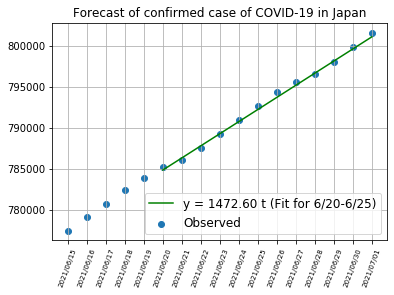

In [33]:
x_latent = np.arange(len(df_pick["2021-06-15":]))
plt.scatter(x_latent, df_pick["Japan", "Cumulative_cases"]["2021-06-15":], label="Observed")
plt.xticks(x_latent, df_pick["2021-06-15":].index.strftime("%Y/%m/%d"), fontsize=7, rotation=70);
draw_approx_curve(x_latent, df_pick["Japan", "Cumulative_cases"]["2021-06-15":], range(5,10), 1, color="green", forecast=7, info="(Fit for 6/20-6/25)")
#draw_approx_curve(x_latent, df_pick["Japan", "Cumulative_cases"]["2021-04-01":], range(6, 10), 1, color="orange", forecast=2, info="(Fit for 3/26-3/29)")
#draw_approx_exp_curve(x_latent, df_pick["Japan", "Cumulative_cases"]["2021-06-01":], range(3,9), color="orange", forecast=2, info="(Fit for 4/4-4/9)")

plt.legend(fontsize=12, loc="lower right")
plt.title("Forecast of confirmed case of COVID-19 in Japan")
plt.grid()

USの傾向のグラフ

USで国家非常事態宣言が出されたのは2020/03/13。カリフォルニア州で外出禁止令が出されたのは2020/03/20。ニューヨーク州で外出禁止令が出されたのは2020/03/22。
ワクチンの接種が始まったのは、2020/12/14。2020年中に摂取（1回目)を受けた人は450万人。

In [14]:
len(x_latent)

93

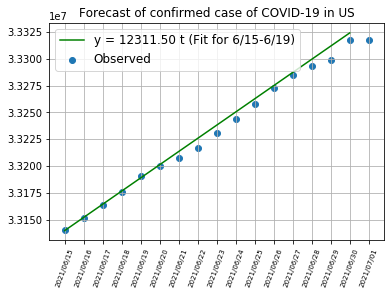

In [37]:
plt.scatter(x_latent, df_pick["USA", "Cumulative_cases"]["2021-06-15":], label="Observed")
plt.xticks(x_latent, df_pick["2021-06-15":].index.strftime("%Y/%m/%d"), fontsize=7, rotation=70);

draw_approx_curve(x_latent, df_pick["USA", "Cumulative_cases"]["2021-06-15":], range(5), 1, forecast=11, color="green", info="(Fit for 6/15-6/19)")
#draw_approx_exp_curve(x_latent, df_pick["USA", "Cumulative_cases"]["2020-11":], range(15), color="orange", forecast=3, info="(Fit for 11/1-11/10)")

plt.legend(fontsize=12, loc="upper left")
plt.title("Forecast of confirmed case of COVID-19 in US")
plt.grid()

各国の新規感染者数の推移

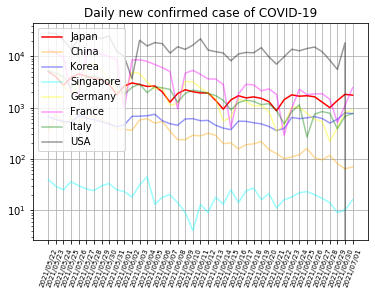

In [16]:
plt.plot(np.arange(d_num), df_pick["Japan", "New_cases"][d_start:d_end], color="red", label="Japan")

for i, c in enumerate(Countries):
    if c != "Japan":
        plt.plot(np.arange(d_num), df_pick[c, "New_cases"][d_start:d_end], color=Ccolor[i], label=c, alpha=0.4)

plt.xticks(np.arange(d_num), df_pick[d_start:d_end].index.strftime("%Y/%m/%d"), fontsize=7, rotation=70);
plt.yscale("log");
plt.grid();
plt.legend(loc="upper left");
plt.title("Daily new confirmed case of COVID-19");
#print(df_diff.max())


日本の新規感染者数

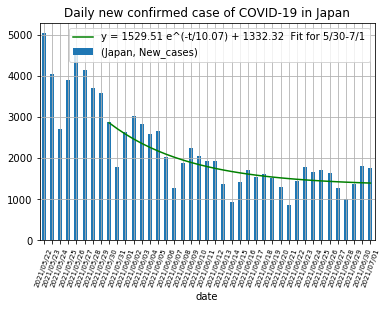

In [38]:
d_end = df_pick["Japan", "New_cases"].last_valid_index()
d_num = len(df_pick[d_start:d_end])
df_pick["Japan", "New_cases"][d_start:d_end].plot(kind="bar")
plt.xticks(np.arange(d_num), df_pick[d_start:d_end].index.strftime("%Y/%m/%d"), fontsize=7, rotation=70);
draw_approx_exp_curve(np.arange(d_num), df_pick["Japan", "New_cases"][d_start:d_end].values, range(8,41), forecast=0, info="Fit for 5/30-7/1")
plt.grid();
plt.legend()
plt.title("Daily new confirmed case of COVID-19 in Japan");

新規感染者数が最大になってからの、毎日の感染者数の推移（割合）

<ipython-input-18-2adcbcc1e135>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pick["China", "New_cases"][indices["China"]] = np.nan


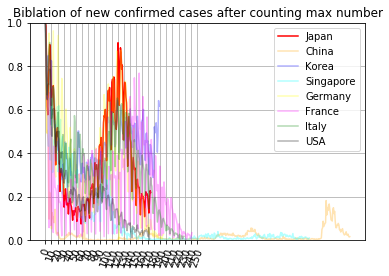

In [18]:
indices = df_pick.loc[slice(None), (slice(None), "New_cases")].idxmax()

df_pick["China", "New_cases"][indices["China"]] = np.nan
indices["China"] = df_pick["China", "New_cases"].idxmax()

plt.plot(df_pick.loc[indices["Japan", "New_cases"]:]["Japan", "New_cases"].dropna().to_numpy()/df_pick.loc[indices["Japan", "New_cases"]]["Japan", "New_cases"], color="red", label="Japan")

for i, c in enumerate(Countries):
    if c != "Japan":
        plt.plot(df_pick.loc[indices[c, "New_cases"]:][c, "New_cases"].dropna().to_numpy()/df_pick.loc[indices[c, "New_cases"]][c, "New_cases"], color=Ccolor[i], label=c, alpha=0.3)

plt.grid();
plt.xticks(range(0,251,10), rotation=70);
plt.ylim((0.,1.))
plt.legend()
plt.title("Biblation of new confirmed cases after counting max number");


## 新規感染者数

In [19]:
for c in Countries:
    #ma7 = df_pick[c, "New_cases"]["2020-08-15":].rolling(7, center=True).mean()
    ma7 = df_pick[c, "New_cases"].rolling(7, center=True).mean()
    ma7.name = "MA7"
    df_pick[c, "MA7"] = df_pick[c].join(ma7, on="date")["MA7"]

df_pick["2020-09-02":"2020-09-04"]

Japan                                                   China  \
           New_cases Cumulative_cases New_deaths Cumulative_deaths New_cases   
date                                                                           
2020-09-02     592.0          69768.0       13.0            1327.0      20.0   
2020-09-03     657.0          70425.0        8.0            1335.0      20.0   
2020-09-04     587.0          71012.0       17.0            1352.0      33.0   

                                                             Korea  \
           Cumulative_cases New_deaths Cumulative_deaths New_cases   
date                                                                 
2020-09-02          90422.0        1.0            4731.0     267.0   
2020-09-03          90442.0        3.0            4734.0     195.0   
2020-09-04          90475.0        1.0            4735.0     198.0   

                             ...               USA day_index       Japan  \
           Cumulative_cases  ... Cumulative_deaths                   MA7   
date                         ...                                           
2020-09-02          20449.0  ...          186802.0         2  586.142857   
2020-09-03          20644.0  ...          187817.0         3  564.857143   
2020-09-04          20842.0  ...          188685.0         4  544.142857   

                China       Korea  Singapore      Germany       France  \
                  MA7         MA7        MA7          MA7          MA7   
date                                                                     
2020-09-02  25.000000  230.000000  40.285714  1144.428571  7330.428571   
2020-09-03  23.714286  211.142857  37.857143  1173.428571  7723.285714   
2020-09-04  24.000000  192.714286  35.857143  1202.571429  8149.142857   

                  Italy           USA  
                    MA7           MA7  
date                                   
2020-09-02  1319.285714  41126.857143  
2020-09-03  1355.000000  41821.428571  
2020-09-04  1345.142857  41880.142857  

[3 rows x 41 columns]

312247.0


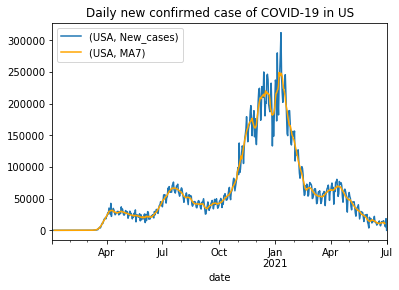

In [20]:

df_pick["USA", "New_cases"].plot()
df_pick["USA", "MA7"].plot(color="orange")

plt.title("Daily new confirmed case of COVID-19 in US")
plt.legend()
print(max(df_pick["USA", "New_cases"].dropna()))

日本の一日の感染者数が最大だった日の人数

In [21]:
print(max(df_pick["Japan", "New_cases"].dropna()))

7957.0


日本の一日の感染者数の曜日ごとの変動幅

[-0.35451144207227026, -0.04778310958272, 0.15330329515227192, 0.13465374220886328, 0.10379241516966058, 0.10310455029675854, -0.08170318270128532]
[0.055487960952380594, 0.026959572012787553, 0.048858524834395185, 0.026980185357411254, 0.03243045017611031, 0.04436817136273545, 0.05365303402898146]


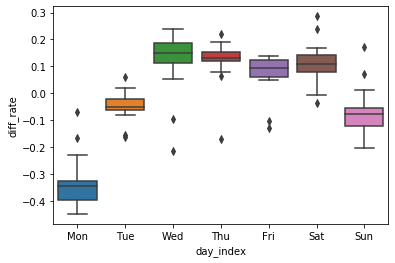

In [22]:
import seaborn as sns

# 移動平均との差分の割合
diff_ma7 = (df_pick["Japan", "New_cases"] - df_pick["Japan", "MA7"])/df_pick["Japan", "MA7"]

df_rate = pd.DataFrame({"diff_rate":diff_ma7})
# 曜日インデックス ## 月曜日=0, 日曜日=6
df_rate["day_index"] = df_rate.index.dayofweek
# 1日に50人以上の感染者数を出した日を抽出（元の数が少ないと割合を算出したときのブレが大きくなるため）
df_rate = df_rate[df_pick["Japan", "New_cases"] > 50]
df_rate = df_rate.dropna()
# 直近半年(12週)の傾向に絞る
df_rate = df_rate[pd.Timestamp.today() - offsets.Week(6*4):]

# 曜日毎の傾向を箱ひげ図で表示
sns.boxplot(data=df_rate, x="day_index", y="diff_rate")
plt.xticks(range(7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]);

trend_day = []
std_day = []
for i in range(7):
    data = df_rate[df_rate["day_index"]==i]["diff_rate"]
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lim_l = q1 - 1.5 * iqr
    lim_u = q3 + 1.5 * iqr
    # 外れ値除去
    data = data[(lim_l < data) & (data < lim_u)]
    trend_day.append(np.median(data))
    std_day.append(np.std(data, ddof=1))

print(trend_day)
print(std_day)

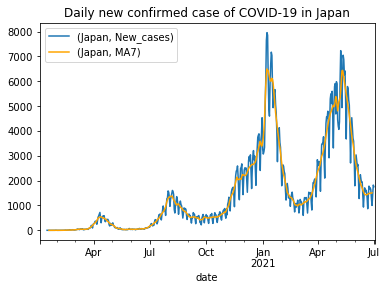

In [23]:
df_pick["Japan", "New_cases"].plot()
df_pick["Japan", "MA7"].plot(color="orange")
plt.legend()
plt.title("Daily new confirmed case of COVID-19 in Japan");

## 7日間移動平均の指数関数近似

## 7日間移動平均のLogの1次関数近似

In [24]:
from collections import deque

class rolling_fit:
    def __init__(self):
        self.res2 = deque()

    def a(self, y):
        intercept = y.values[0]
        y = y.values - intercept
        x = range(len(y))
        coef = np.polyfit(x, y, 1)
        coef[1] += intercept

        self.res2.append(coef[1])

        return coef[0]

    def b(self, y):
        return self.res2.popleft()

f = rolling_fit()
ctry = "Japan"
malog = np.log(df_pick[ctry, "MA7"])
mae = malog.rolling(7, center=True).agg({"a":f.a, "b":f.b})
df_pick[ctry, "e_a"] = mae["a"]
df_pick[ctry, "e_b"] = mae["b"]
df_pick.head()

C:\Users\yoneken\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Japan                                                   China  \
           New_cases Cumulative_cases New_deaths Cumulative_deaths New_cases   
date                                                                           
2020-01-04       NaN              NaN        NaN               NaN       1.0   
2020-01-05       NaN              NaN        NaN               NaN       0.0   
2020-01-06       NaN              NaN        NaN               NaN       3.0   
2020-01-07       NaN              NaN        NaN               NaN       0.0   
2020-01-08       NaN              NaN        NaN               NaN       0.0   

                                                             Korea  \
           Cumulative_cases New_deaths Cumulative_deaths New_cases   
date                                                                 
2020-01-04              1.0        0.0               0.0       0.0   
2020-01-05              1.0        0.0               0.0       0.0   
2020-01-06              4.0        0.0               0.0       0.0   
2020-01-07              4.0        0.0               0.0       0.0   
2020-01-08              4.0        0.0               0.0       0.0   

                             ... Japan     China Korea Singapore Germany  \
           Cumulative_cases  ...   MA7       MA7   MA7       MA7     MA7   
date                         ...                                           
2020-01-04              0.0  ...   NaN       NaN   NaN       NaN     NaN   
2020-01-05              0.0  ...   NaN       NaN   NaN       NaN     NaN   
2020-01-06              0.0  ...   NaN       NaN   NaN       NaN     NaN   
2020-01-07              0.0  ...   NaN  0.571429   0.0       0.0     0.0   
2020-01-08              0.0  ...   NaN  0.428571   0.0       0.0     0.0   

           France Italy  USA Japan      
              MA7   MA7  MA7   e_a e_b  
date                                    
2020-01-04    NaN   NaN  NaN   NaN NaN  
2020-01-05    NaN   NaN  NaN   NaN NaN  
2020-01-06    NaN   NaN  NaN   NaN NaN  
2020-01-07    0.0   0.0  0.0   NaN NaN  
2020-01-08    0.0   0.0  0.0   NaN NaN  

[5 rows x 43 columns]

新規感染者数がe^tの指数関数と曜日毎の変動という単純な2要素のみで近似できる（実際にはそんなことはない）と仮定した外挿モデルによる、1日先予測

In [25]:
forecast = 1

df_pick[ctry, "predict"] = df_pick.apply(lambda d: np.exp(d[ctry, "e_a"] * (9+forecast) + d[ctry, "e_b"])*(1+trend_day[int(d["day_index"].values[0])]), axis=1)
df_pick[ctry, "predict_u"] = df_pick.apply(lambda d: np.exp(d[ctry, "e_a"] * (9+forecast) + d[ctry, "e_b"])*(1+trend_day[int(d["day_index"].values[0])]+2*std_day[int(d["day_index"].values[0])]), axis=1)
df_pick[ctry, "predict_l"] = df_pick.apply(lambda d: np.exp(d[ctry, "e_a"] * (9+forecast) + d[ctry, "e_b"])*(1+trend_day[int(d["day_index"].values[0])]-2*std_day[int(d["day_index"].values[0])]), axis=1)
df_pick.tail()

Japan                                                   China  \
           New_cases Cumulative_cases New_deaths Cumulative_deaths New_cases   
date                                                                           
2021-06-28    1001.0         796598.0       38.0           14713.0     117.0   
2021-06-29    1380.0         797978.0       30.0           14743.0      81.0   
2021-06-30    1821.0         799799.0       41.0           14784.0      64.0   
2021-07-01    1754.0         801553.0       24.0           14808.0      70.0   
2021-07-02       NaN              NaN        NaN               NaN       NaN   

                                                             Korea  \
           Cumulative_cases New_deaths Cumulative_deaths New_cases   
date                                                                 
2021-06-28         118358.0        9.0            5478.0     501.0   
2021-06-29         118439.0        3.0            5481.0     595.0   
2021-06-30         118503.0        9.0            5490.0     794.0   
2021-07-01         118573.0        5.0            5495.0     762.0   
2021-07-02              NaN        NaN               NaN       NaN   

                             ...  Singapore     Germany       France  \
           Cumulative_cases  ...        MA7         MA7          MA7   
date                         ...                                       
2021-06-28         155572.0  ...  15.571429  603.857143  1578.571429   
2021-06-29         156167.0  ...        NaN         NaN          NaN   
2021-06-30         156961.0  ...        NaN         NaN          NaN   
2021-07-01         157723.0  ...        NaN         NaN          NaN   
2021-07-02              NaN  ...        NaN         NaN          NaN   

                 Italy           USA Japan                                  
                   MA7           MA7   e_a e_b predict predict_u predict_l  
date                                                                        
2021-06-28  639.285714  10610.571429   NaN NaN     NaN       NaN       NaN  
2021-06-29         NaN           NaN   NaN NaN     NaN       NaN       NaN  
2021-06-30         NaN           NaN   NaN NaN     NaN       NaN       NaN  
2021-07-01         NaN           NaN   NaN NaN     NaN       NaN       NaN  
2021-07-02         NaN           NaN   NaN NaN     NaN       NaN       NaN  

[5 rows x 46 columns]

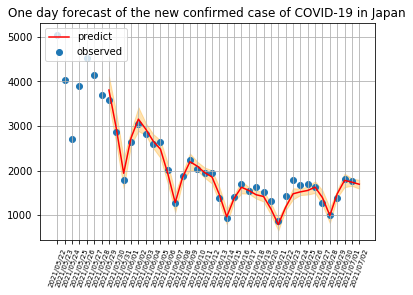

In [26]:
df_roi = df_pick[d_start:d_end]
plt.plot(np.arange(6+forecast, d_num+6+forecast), df_roi[ctry, "predict"], color="red", label="predict")
plt.fill_between(np.arange(6+forecast, d_num+6+forecast), df_roi[ctry, "predict_l"], df_roi[ctry, "predict_u"], color="orange", alpha=0.3)
plt.scatter(np.arange(d_num), df_roi[ctry, "New_cases"], label="observed")

plt.xticks(np.arange(d_num+forecast), pd.date_range(start=d_start+offsets.Day(forecast), end=d_end+offsets.Day(forecast+1), freq="D").strftime("%Y/%m/%d"), fontsize=7, rotation=70);
plt.grid()
plt.legend(loc="upper left");
plt.title("One day forecast of the new confirmed case of COVID-19 in " + ctry)
plt.show()
#print([df_new_pick.predict_d.iloc[-8-11], df_new_pick.predict.iloc[-8-11], df_new_pick.predict_u.iloc[-8-11]])
